In [1]:

import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Check for TensorFlow GPU access
print(tf.config.list_physical_devices())

# See TensorFlow version
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
2.9.1


In [2]:
base_dir = '../data/fruits-360/'
test_dir = os.path.join(base_dir, 'Test')
train_dir = os.path.join(base_dir, 'Training')

train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir) 

In [3]:
# Img size

img_height = 224
img_width = 224

In [4]:
# VGG16 Model 

# Data preprocessing - ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,# Image augmentaion 
    shear_range=0.2,
    zoom_range=0.2, # Zoom in on image by 20%
    horizontal_flip=True, #  Flip the image horizontally
    validation_split=0.2) # Split 20% of the data for validation

# Normalize the test data images
test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='training') # Set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir, # Same directory as training data
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # Set as validation data

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical')

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [5]:
# Create the model based on VGG16

base_model = tf.keras.applications.VGG16(include_top=False,
                                    weights="imagenet",
                                    input_shape=(img_height, img_width, 3))

# Freeze the layers
base_model.trainable = False

Vgg = base_model.output
Vgg = GlobalAveragePooling2D()(Vgg)
#Vgg = Dropout(0.20)(Vgg)
predictions = Dense(131, activation= 'softmax')(Vgg)
Vgg = Model(inputs = base_model.input, outputs = predictions)

opt = Adam(lr=0.01)
Vgg.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

Vgg.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

C:\Users\Nick\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:


history = Vgg.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        verbose = 1,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])



Epoch 1/10
1694/1694 [==============================] - 5160s 3s/step - loss: 1.2993 - accuracy: 0.7545 - val_loss: 0.5406 - val_accuracy: 0.9077
Epoch 2/10
1694/1694 [==============================] - 5063s 3s/step - loss: 0.2926 - accuracy: 0.9542 - val_loss: 0.3151 - val_accuracy: 0.9285
Epoch 3/10
1694/1694 [==============================] - 5051s 3s/step - loss: 0.1556 - accuracy: 0.9754 - val_loss: 0.2347 - val_accuracy: 0.9416
Epoch 4/10
1694/1694 [==============================] - 5002s 3s/step - loss: 0.1033 - accuracy: 0.9828 - val_loss: 0.2394 - val_accuracy: 0.9339
Epoch 5/10
1694/1694 [==============================] - 5012s 3s/step - loss: 0.0801 - accuracy: 0.9848 - val_loss: 0.1508 - val_accuracy: 0.9589
Epoch 6/10
1694/1694 [==============================] - 5010s 3s/step - loss: 0.0602 - accuracy: 0.9881 - val_loss: 0.1371 - val_accuracy: 0.9616
Epoch 7/10
1694/1694 [==============================] - 5026s 3s/step - loss: 0.0513 - accuracy: 0.9882 - val_loss: 0.1019 -

In [13]:
# Save the model VGG
def save_model(model, seed):
    model.save(f"../models/vgg16v1-{seed}")
    
save_model(Vgg, 1)

INFO:tensorflow:Assets written to: ../models/vgg16v1-1\assets


INFO:tensorflow:Assets written to: ../models/vgg16v1-1\assets


In [8]:
# Test the model

loss, accuracy = Vgg.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.3f}, Test loss: {loss:.3f}')

709/709 [==============================] - 1671s 2s/step - loss: 0.1945 - accuracy: 0.9536
Test accuracy: 0.954, Test loss: 0.195


Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

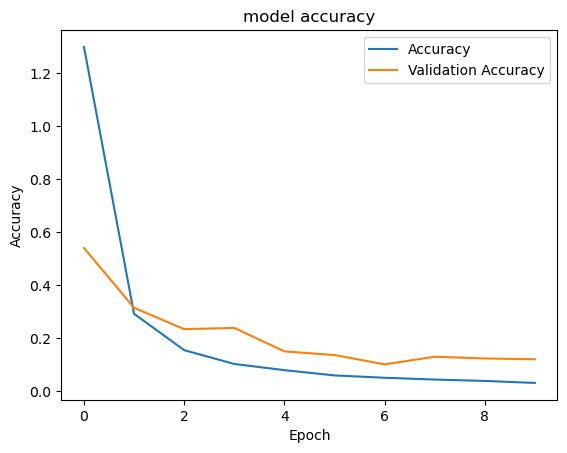

In [12]:
#plt.plot(history.history["acc"])
#plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()